In [80]:
#yahoo finance as data source
#pip install yfinance
import yfinance as yf

In [81]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = '^NSEI'

In [82]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='7d',interval='1m')

[*********************100%***********************]  1 of 1 completed


In [83]:
type(data)

pandas.core.frame.DataFrame

In [84]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-11-02 09:15:00,18177.900391,18177.900391,18129.800781,18144.199219,18144.199219,0
2022-11-02 09:16:00,18144.349609,18144.349609,18133.599609,18138.650391,18138.650391,0
2022-11-02 09:17:00,18139.099609,18139.099609,18118.800781,18124.250000,18124.250000,0
2022-11-02 09:18:00,18121.900391,18122.400391,18110.699219,18122.150391,18122.150391,0
2022-11-02 09:19:00,18121.599609,18131.250000,18120.699219,18128.849609,18128.849609,0


In [85]:
len(data)

2623

In [86]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-11-11 15:26:00,18351.849609,18357.500000,18351.699219,18357.000000,18357.000000,0
2022-11-11 15:27:00,18357.849609,18359.050781,18355.000000,18356.099609,18356.099609,0
2022-11-11 15:28:00,18356.349609,18358.449219,18353.300781,18354.099609,18354.099609,0
2022-11-11 15:29:00,18353.949219,18360.000000,18351.050781,18355.300781,18355.300781,0
2022-11-11 15:30:00,18349.699219,18349.699219,18349.699219,18349.699219,18349.699219,0


In [87]:
opn = data[['Open']]

<AxesSubplot:xlabel='Datetime'>

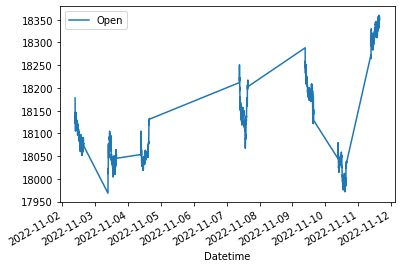

In [88]:
opn.plot()

In [89]:
import matplotlib.pyplot as plt

In [90]:
ds = opn.values

In [91]:
ds

array([[18177.90039062],
       [18144.34960938],
       [18139.09960938],
       ...,
       [18356.34960938],
       [18353.94921875],
       [18349.69921875]])

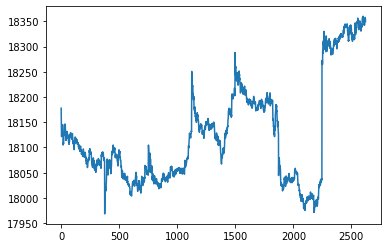

In [92]:
plt.plot(ds)

In [93]:
import numpy as np

In [94]:
from sklearn.preprocessing import MinMaxScaler

In [95]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [96]:
len(ds_scaled), len(ds)

(2623, 2623)

In [97]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [98]:
train_size,test_size

(1836, 787)

In [99]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [100]:
len(ds_train),len(ds_test)

(1836, 787)

In [101]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [102]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [103]:
X_train.shape,y_train.shape

((1735, 100), (1735,))

In [104]:
X_test.shape, y_test.shape

((686, 100), (686,))

In [105]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [106]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [107]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [108]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/100
28/28 [==============================] - 9s 137ms/step - loss: 0.0471 - val_loss: 0.0209
Epoch 2/100
28/28 [==============================] - 3s 95ms/step - loss: 0.0026 - val_loss: 0.0060
Epoch 3/100
28/28 [==============================] - 3s 96ms/step - loss: 0.0016 - val_loss: 0.0059
Epoch 4/100
28/28 [==============================] - 3s 98ms/step - loss: 0.0017 - val_loss: 0.0063
Epoch 5/100
28/28 [==============================] - 3s 97ms/step - loss: 0.0013 - val_loss: 0.0064
Epoch 6/100
28/28 [==============================] - 3s 95ms/step - loss: 0.0016 - val_loss: 0.0051
Epoch 7/100
28/28 [==============================] - 3s 95ms/step - loss: 0.0014 - val_loss: 0.0060
Epoch 8/100
28/28 [==============================] - 3s 95ms/step - loss: 0.0014 - val_loss: 0.0058
Epoch 9/100
28/28 [==============================] - 3s 95ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 10/100
28/28 [==============================] - 3s 96ms/step - loss: 0.0015 - val_loss: 0.004

KeyboardInterrupt: 

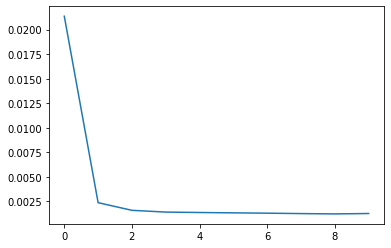

In [109]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [110]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [111]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

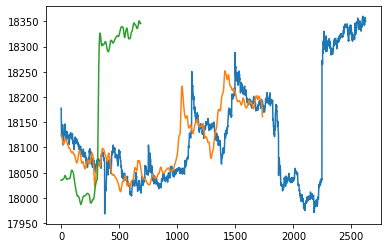

In [112]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [113]:
type(train_predict)

numpy.ndarray

In [114]:
test = np.vstack((train_predict,test_predict))

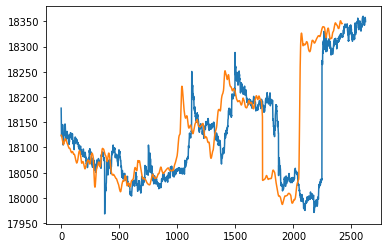

In [115]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [118]:
len(ds_test)

787

In [119]:
#Getting the last 500 minutes records
fut_inp = ds_test[287:]

In [120]:
fut_inp = fut_inp.reshape(1,-1)

In [121]:
tmp_inp = list(fut_inp)

In [122]:
fut_inp.shape

(1, 500)

In [123]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [126]:
#Predicting next 30 minutes price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=500
i=0
while(i<30):
    
    if(len(tmp_inp)>500):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.942920982837677], [0.9420394897460938], [0.9411691427230835], [0.9403097629547119], [0.9394611716270447], [0.9386236071586609], [0.9377970695495605], [0.9369810223579407], [0.9361756443977356], [0.9353809952735901], [0.9345965385437012], [0.9338226914405823], [0.9330589175224304], [0.9323049783706665], [0.9315611124038696], [0.9308272004127502], [0.9301030039787292], [0.9293882846832275], [0.9286829829216003], [0.9279869198799133], [0.9273000359535217], [0.9266220927238464], [0.9259530901908875], [0.9252928495407104], [0.9246411919593811], [0.9239980578422546], [0.9233631491661072], [0.922736644744873], [0.9221181273460388], [0.9215076565742493]]


In [127]:
len(ds_scaled)

2623

In [133]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

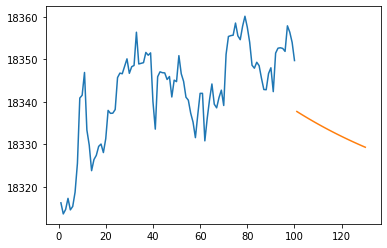

In [134]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[2523:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [135]:
ds_new = ds_scaled.tolist()

In [136]:
len(ds_new)

2623

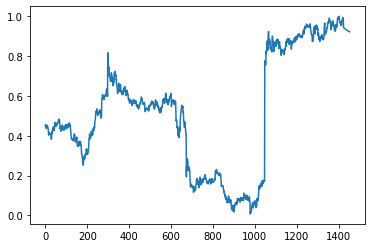

In [137]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [138]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

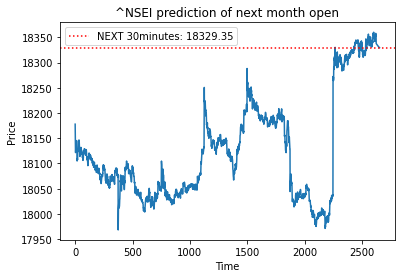

In [140]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30minutes: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

